## <font color='#2F4F4F'>Text Classification with Python</font>

## <font color='#2F4F4F'>Step 1. Business Understading </font>

###Background Information
You work as a Computational Linguist for a Global firm, collaborating with Engineers and
Researchers in Assistant and Research & Machine Intelligence to develop language
understanding models that improve our ability to understand and generate natural
language.


### The Research Question

Build a text classification model that classifies a given text input as written in english or in dutch.

### Metric of Success
Build a classification model with an accuracy of score of atleast 85%.

### The Experimental Design

* Business Understanding
* Library Importation
* Data Importation & Exploration
* Data Preparation
* Data Modeling and Evaluation
* Summary of Findings & Recommendation
* Challenging the Solution


## <font color='#2F4F4F'>Step 2. Library Importation</font>

In [1]:
# import the required libraries

import pandas as pd # library for data manipulation
import numpy as np  # librariy for scientific computations
import re           # regex library to perform text preprocessing
import string       # library to work with strings
import nltk         # library for natural language processing
import scipy        # scientific computing 
import seaborn as sns # library for data visualisation

# to display all columns
pd.set_option('display.max.columns', None)

# to display the entire contents of a cell
pd.set_option('display.max_colwidth', None)

# Library for Stop words
!pip3 install wordninja
!pip3 install textblob
import wordninja 
from textblob import TextBlob

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Library for Lemmatization
nltk.download('wordnet')
from textblob import Word

# Library for Noun count
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Library for TD-IDF
from sklearn.feature_extraction.text import TfidfVectorizer 

# Library for metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('omw-1.4')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 541 kB 16.0 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=5c2d59bcfa7144d094bbba85fb2669446b5c5946316bbb878f35c338c1558c4b
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
# Custom Functions
# ---
#

# Avg. words
def avg_word(sentence):
  words = sentence.split()
  try:
    z = (sum(len(word) for word in words)/len(words))
  except ZeroDivisionError:
    z = 0 
  return z

# Noun count
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

import sys
if sys.version_info[0] >= 3:
    unicode = str
    
# Subjectivity 
def get_subjectivity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

# Polarity
def get_polarity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

## <font color='#2F4F4F'>Step 3. Data Importation & Exploration</font>

In [23]:
# load and preview the dataset
df = pd.read_csv('http://bit.ly/EnglishNDutchDs') 
df.sample(5)

,text,label
717,De kerk is gebouwd op La Garde een meter hoge kalkstenen rots aan de zuidkant,nl
719,Bij de basiliek staat een meter hoge klokkentoren met op de top daarvan een enorm,nl
545,onderhandelen. De missie mislukte doordat de Turken te hoge eisen stelden en doordat tegelijk de,nl
572,two elder sisters remained at Hohenburg where each served as abbess. At her own death,en
516,"the bridge provide, this stretch of the river is now only used by recreational and",en


In [5]:
# check dataset shape
df.shape

(1069, 2)

Our dataset has 1069 records and 2 variables.

In [6]:
# preview variable datatypes
df.dtypes

text     object
label    object
dtype: object

Both variables have the data type object. This is fine for the text variable, however for the label, we will need to convert it to a numerical format. We will do this later.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


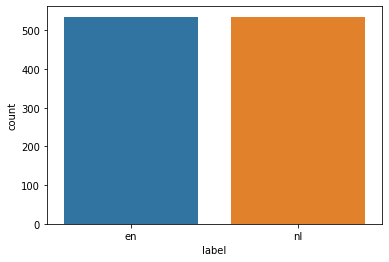

In [7]:
# plot the distribution of label
# ---
#
sns.countplot(df['label']);

In [8]:
# investigating the label distribution
df['label'].value_counts()

nl    535
en    534
Name: label, dtype: int64

From above, we can see that our dataset is unbalanced thus we will need to sample equal no. of records for each label during data preparation to make a balanced dataset.

## <font color='#2F4F4F'>Step 4. Data Preparation</font>

### <font color='#2F4F4F'>3.1 Data Cleaning</font>

In [15]:
# check for duplicates
df.duplicated().sum()

10

There are 10 duplicates. We will need to drop these.

In [16]:
# check for missing values
df.isna().sum()

text     0
label    0
dtype: int64

No missing values found. 

In [24]:
# drop duplicates
df = df.drop_duplicates()
df.shape

(1059, 2)

In [18]:
# What values are in our label variable?

df.label.unique()

array(['en', 'nl'], dtype=object)

In [27]:
# sampling text with en 
df_en = df[df["label"] == 'en'] 
df_en = df_en.sample(527)

# sampling text with nl 
df_nl = df[df["label"] == 'nl'] 
df_nl = df_nl.sample(527)

# combining our dataframes
df = pd.concat([df_en, df_nl])
df.head()

,text,label
931,Susukino is often noted as 薄野 in kanji and ススキノ in katakana and directly translated,en
228,"the genetic of India, unfolding the and highly of women,[30] the on Empires of was",en
889,Owned by Dr Kamal Ahuja and founded in the centre has a reputation for helping,en
54,"The at Hlabisa, Conference of as leader Municipality, became National party as at the leader",en
505,"tuples. A decision tree is a flow-chart-like structure, where each internal (non-leaf) node denotes a",en


In [28]:
# investigating the label distribution
df['label'].value_counts()

en    527
nl    527
Name: label, dtype: int64

We now have our balanced dataset. 

### <font color='#2F4F4F'> 3.2 Text Cleaning</font>

In [31]:
# We will create a custom function that will contain all the text cleaning 
# techniques. We can then reuse the same function for cleaning new data
# without rewriting the code.
# ---

def text_cleaning(text):
  # Removing url/links
  df['text'] = df.text.apply(lambda x: re.sub(r'http\S+|www\S+|https\S+','', str(x)))

  # Removing @ and # characters and replacing them with space
  df['text'] = df.text.str.replace('#',' ')
  df['text'] = df.text.str.replace('@',' ') 

  # Conversion to lowercase 
  df['text'] = df.text.apply(lambda x: " ".join(x.lower() for x in x.split()))

  # Removing punctuation characters
  df['text'] = df.text.str.replace('[^\w\s]','')

  # Removing stop words
  df['text'] = df.text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # Lemmatization
  df['text'] = df.text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [34]:
# Applying the text_cleaning function to our dataframe.
# ---

df.text.apply(text_cleaning)
df.sample(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.


,text,label
77,african firstyear secondyears38 gave elite student mandela decade black,en
146,although rump returned restoration safety resignation living,en
918,make impractical construct permanent station north pole unlike,en
614,despite popular crew encouraged french practice,en
713,de volgende frazioni maken deel uit van de gemeente santippolito san quirico montepiano en mercatale,nl
760,de wetenschappelijke naam van de soort werd voor het eerst geldig gepubliceerd door pic,nl
469,plaats oud zijn hij bleef hugo ronaldo en te van aveiro kok unitedshirts advies negentien,nl
831,hoewel de serie hollywood werd opgenomen werden wel beelden van boulder de serie,nl
235,gautama teaching kingdom thought renunciation separated empirebuilding century two,en
313,en de thomas hij door maar liever huidige dat geleerde van beroemd van hij,nl


### <font color='#2F4F4F'> 3.3 Feature Engineering</font>

In [35]:
# We will create a custom function that will contain all the 
# feature engineering techniques. We can then use this function 
# to create new feautures. 
# ---

def feature_engineering(text):
  # Length of text
  df['length_of_text'] = df.text.str.len()

  # Word count 
  df['word_count'] = df.text.apply(lambda x: len(str(x).split(" ")))

  # Word density (Average no. of words / text)
  df['avg_word_length'] = df.text.apply(lambda x: avg_word(x)) 
  
  # Noun Count
  df['noun_count'] = df.text.apply(lambda x: pos_check(x, 'noun'))

  # Verb Count
  df['verb_count'] = df.text.apply(lambda x: pos_check(x, 'verb'))

  # Adjective Count / text
  df['adj_count'] = df.text.apply(lambda x: pos_check(x, 'adj'))

  # Adverb Count / text
  df['adv_count'] = df.text.apply(lambda x: pos_check(x, 'adv'))

  # Pronoun 
  df['pron_count'] = df.text.apply(lambda x: pos_check(x, 'pron'))

  # Subjectivity 
  df['subjectivity'] = df.text.apply(get_subjectivity)

  # Polarity
  df['polarity'] = df.text.apply(get_polarity)

In [36]:
# Applying the custom feature engineering function to our dataframe.
# ---

df.text.apply(feature_engineering)
df.sample(10)

,text,label,length_of_text,word_count,avg_word_length,noun_count,verb_count,adj_count,adv_count,pron_count,subjectivity,polarity
452,blessure hij te hem el aan van zijn el middenvoetsbeentje november de na,nl,72,13,4.615385,6,2,2,0,0,0.0,0.0
304,de al op opgericht aan snel stanforduniversiteit page de wereldwijde werelds zoekmachine brin veel,nl,98,14,6.071429,4,1,1,0,0,0.0,0.0
876,jasjit singh gill born december better known jimmy sheirgill indian actor,en,73,11,5.727273,6,3,2,0,0,0.0,0.0
467,zich maar zijn overwoog om op kind dolores zij miskraam vervolgens totdat te,nl,76,13,4.923077,9,2,1,0,0,0.0,0.0
119,peasant london form increasingly sophistication treasury around,en,63,7,8.142857,2,0,3,1,0,0.0,0.0
67,south lawyer branch fort system umkhonto cofounded,en,50,7,6.285714,5,1,1,0,0,0.0,0.0
830,jaarlijks wordt de zomer een shakespearefestival gehouden het theater van de universiteit van,nl,93,13,6.230769,7,0,2,0,0,0.0,0.0
966,located north col de la forclaz geographically part,en,51,8,5.500000,2,1,1,1,0,0.0,0.0
385,usfl definitief plan met het state andere de national door gehoopt werd uit vervangen kreeg,nl,91,15,5.133333,9,1,3,0,0,0.0,0.0
299,bedacht opstarten gate hiervan bedrijf nieuw met ceo zien akkoord het interesse paul een de,nl,91,15,5.133333,10,1,3,0,0,0.0,0.0


In [38]:
# Perform further feature engineering techniques
# Feature Construction: Word Level N-Gram TF-IDF Feature 
# ---
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', ngram_range=(1,3),  stop_words= 'english')
df_word_vect = tfidf.fit_transform(df.text) 

# Feature Construction: Character Level N-Gram TF-IDF 
# ---
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char', ngram_range=(1,3),  stop_words= 'english')
df_char_vect = tfidf.fit_transform(df.text)

In [41]:
# Let's prepare the constructed features for modeling
# We will select all variables but the target (which is the label) and text variables 
# ---

# X_metadata = np.array(df[['text',	'length_of_text',	'word_count',	'avg_word_length',	'noun_count',	'verb_count',	'adj_count',	'adv_count',	'pron_count',	'subjectivity',	'polarity']])
X_metadata = np.array(df[df.columns.difference(['label', 'text'])])
X_metadata

array([[ 0.        ,  2.        ,  6.11111111, ...,  0.        ,
         2.        ,  9.        ],
       [ 2.        ,  1.        ,  6.66666667, ...,  0.        ,
         1.        ,  6.        ],
       [ 2.        ,  0.        ,  5.875     , ...,  0.        ,
         3.        ,  8.        ],
       ...,
       [ 1.        ,  0.        ,  5.66666667, ...,  0.        ,
         0.        , 15.        ],
       [ 0.        ,  1.        ,  6.78571429, ...,  0.        ,
         1.        , 14.        ],
       [ 1.        ,  0.        ,  5.21428571, ...,  0.        ,
         1.        , 14.        ]])

In [42]:
# We combine our two tfidf (sparse) matrices and X_metadata
# ---

X = scipy.sparse.hstack([df_word_vect, df_char_vect, X_metadata])
X

<1054x2010 sparse matrix of type '<class 'numpy.float64'>'
	with 136567 stored elements in COOrdinate format>

In [43]:
# Label Preparation i.e. replacing categorial values with numerical ones
# ---  

y = np.array(df['label'].replace(['en', 'nl'], ['0','1']))
y

array(['0', '0', '0', ..., '1', '1', '1'], dtype=object)

##  <font color='#2F4F4F'>Step 5. Data Modeling & Evaluation</font>

We will use the following classifiers:
1.  Logistic Regression
3.  Decision Tree
4.  Support Vector Machine (SVM)
5. K-Nearest Neighbors (KNN)
6.  Gaussian Naive Bayes (NB)
7.  BaggingClassifier
8.  RandomForestClassifier
9.  AdaBoostClassifier
10. GradientBoostingClassifier
11. XGBClassifier

We use their default parameters then compare the different classification models to assess the best performing one(s). 

In [44]:
# splitting into 80-20 train-test sets
# ---

from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# import the algorithms
# ---

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# ensemble classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

In [46]:
# instantiate the classifiers
# ---

logistic_classifier = LogisticRegression(solver='saga', max_iter=800, multi_class='multinomial') # solver works well with a large dataset like ours
decision_classifier = DecisionTreeClassifier(random_state=42)
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier()
naive_classifier = MultinomialNB() 
bagging_meta_classifier = BaggingClassifier()
random_forest_classifier = RandomForestClassifier()
ada_boost_classifier = AdaBoostClassifier(random_state=42)
gbm_classifier = GradientBoostingClassifier(random_state=42) 
xg_boost_classifier = xgb.XGBClassifier() 

In [47]:
# fit the classifiers to the training data
# ---

logistic_classifier.fit(features_train, target_train)
decision_classifier.fit(features_train, target_train)
svm_classifier.fit(features_train, target_train)
knn_classifier.fit(features_train, target_train)
naive_classifier.fit(features_train, target_train) 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


MultinomialNB()

In [48]:
bagging_meta_classifier.fit(features_train, target_train)
random_forest_classifier.fit(features_train, target_train)
ada_boost_classifier.fit(features_train, target_train)
gbm_classifier.fit(features_train, target_train)
xg_boost_classifier.fit(features_train, target_train)

XGBClassifier()

In [49]:
# make predictions
# ---

logistic_y_prediction = logistic_classifier.predict(features_test) 
decision_y_prediction = decision_classifier.predict(features_test) 
svm_y_prediction = svm_classifier.predict(features_test) 
knn_y_prediction = knn_classifier.predict(features_test) 
naive_y_prediction = naive_classifier.predict(features_test)  

In [50]:
bagging_y_classifier = bagging_meta_classifier.predict(features_test) 
random_forest_y_classifier = random_forest_classifier.predict(features_test) 
ada_boost_y_classifier = ada_boost_classifier.predict(features_test)
gbm_y_classifier = gbm_classifier.predict(features_test)
xg_boost_y_classifier = xg_boost_classifier.predict(features_test)

Model Evaluation

In [51]:
# Accuracy scores
# ---

print("Logistic Regression Classifier", accuracy_score(logistic_y_prediction, target_test))
print("Decision Trees Classifier", accuracy_score(decision_y_prediction, target_test))
print("SVN Classifier", accuracy_score(svm_y_prediction, target_test))
print("KNN Classifier", accuracy_score(knn_y_prediction, target_test))
print("Naive Bayes Classifier", accuracy_score(naive_y_prediction, target_test))
print("Bagging Classifier", accuracy_score(bagging_y_classifier, target_test))
print("Random Forest Classifier", accuracy_score(random_forest_y_classifier, target_test))
print("Ada Boost Classifier", accuracy_score(ada_boost_y_classifier, target_test))
print("GBM Classifier", accuracy_score(gbm_y_classifier, target_test))
print("XGBoost Classifier", accuracy_score(xg_boost_y_classifier, target_test))

Logistic Regression Classifier 0.990521327014218
Decision Trees Classifier 0.9383886255924171
SVN Classifier 0.9004739336492891
KNN Classifier 0.9620853080568721
Naive Bayes Classifier 1.0
Bagging Classifier 0.9715639810426541
Random Forest Classifier 1.0
Ada Boost Classifier 0.990521327014218
GBM Classifier 0.990521327014218
XGBoost Classifier 0.990521327014218


Random Forest and Naive Bayes Classifiers were the best models, followed closely by Logistic Regression, Ada Boost, GBM and XGBoost Classifiers.

In [52]:
# Confusion matrices
# ---

print('Logistic Regression Classifier:') 
print(confusion_matrix(logistic_y_prediction, target_test))

print('Decision Trees Classifier:')
print(confusion_matrix(decision_y_prediction, target_test))

print('SVN Classifier:')
print(confusion_matrix(svm_y_prediction, target_test))

print('KNN Classifier:')
print(confusion_matrix(knn_y_prediction, target_test))

print('Naive Bayes Classifier:')
print(confusion_matrix(naive_y_prediction, target_test))
 
print('Bagging Classifier:')
print(confusion_matrix(bagging_y_classifier, target_test))

print('Random Forest Classifier:')
print(confusion_matrix(random_forest_y_classifier, target_test))

print('Ada Boost Classifier:')
print(confusion_matrix(ada_boost_y_classifier, target_test))

print('GBM Classifier:')
print(confusion_matrix(gbm_y_classifier, target_test))

print('XGBoost Classifier:')
print(confusion_matrix(xg_boost_y_classifier, target_test))

Logistic Regression Classifier:
[[113   2]
 [  0  96]]
Decision Trees Classifier:
[[106   6]
 [  7  92]]
SVN Classifier:
[[99  7]
 [14 91]]
KNN Classifier:
[[110   5]
 [  3  93]]
Naive Bayes Classifier:
[[113   0]
 [  0  98]]
Bagging Classifier:
[[110   3]
 [  3  95]]
Random Forest Classifier:
[[113   0]
 [  0  98]]
Ada Boost Classifier:
[[111   0]
 [  2  98]]
GBM Classifier:
[[112   1]
 [  1  97]]
XGBoost Classifier:
[[112   1]
 [  1  97]]


Random Forest and Naive Bayes Classifiers did not have any FPs or FNs

In [53]:
# Classification Reports
# ---

print("Logistic Regression Classifier", classification_report(logistic_y_prediction, target_test))
print("Decision Trees Classifier", classification_report(decision_y_prediction, target_test))
print("SVM Classifier", classification_report(svm_y_prediction, target_test))
print("KNN Classifier", classification_report(knn_y_prediction, target_test))
print("Naive Bayes Classifier", classification_report(naive_y_prediction, target_test))
print("Bagging Classifier", classification_report(bagging_y_classifier, target_test))
print("Random Forest Classifier", classification_report(random_forest_y_classifier, target_test))
print("Ada Boost Classifier", classification_report(ada_boost_y_classifier, target_test))
print("GBM Classifier", classification_report(gbm_y_classifier, target_test))
print("XGBoost Classifier", classification_report(xg_boost_y_classifier, target_test))

Logistic Regression Classifier               precision    recall  f1-score   support

           0       1.00      0.98      0.99       115
           1       0.98      1.00      0.99        96

    accuracy                           0.99       211
   macro avg       0.99      0.99      0.99       211
weighted avg       0.99      0.99      0.99       211

Decision Trees Classifier               precision    recall  f1-score   support

           0       0.94      0.95      0.94       112
           1       0.94      0.93      0.93        99

    accuracy                           0.94       211
   macro avg       0.94      0.94      0.94       211
weighted avg       0.94      0.94      0.94       211

SVM Classifier               precision    recall  f1-score   support

           0       0.88      0.93      0.90       106
           1       0.93      0.87      0.90       105

    accuracy                           0.90       211
   macro avg       0.90      0.90      0.90       211
we

**Accuracy:** the percentage of texts that were assigned the correct topic.

**Precision:** the percentage of texts the classifier classified correctly out of the total number of texts it predicted for each topic

**Recall:** the percentage of texts the model predicted for each topic out of the total number of texts it should have predicted for that topic.

**F1 Score:** the average of both precision and recall.

## <font color='#2F4F4F'>Step 6. Summary of Findings and Recommendation</font>

> All our models met the success criteria. 

> Our best performing models were Random Forest and Naive Bayes Classifiers. I recommend using any of these two for text classification.

## <font color='#2F4F4F'>Step 7. Challenging our Solution</font>

Did we have the right question? 
>Yes

Did we have the right data? 
>Yes.

What can be done to improve the solution?

> Although our models achieved the success criteria, we can try perfoming other text processing techniques that would better prepare our data for fitting our model. We can also use different vectorizing techniques, implement other machine learning models, and perform hyperparameter tuning.